In [149]:
%pip install scikit-learn pandas numpy keras matplotlib keras-tuner
# INSTALL TENSORFLOW SEPARATELY pip install "tensorflow<2.11" if on windows
# IF YOU HAVE GPU RECOMMEND INSTALL CUDA AND CUDNN

Note: you may need to restart the kernel to use updated packages.


In [150]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import keras
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping
from keras.layers import LSTM, Dropout, Dense, BatchNormalization, Input
import random
from keras_tuner import HyperModel
from keras_tuner.tuners import RandomSearch

In [151]:
import tensorflow as tf

# Check if GPU is available
# Trust me you prefer using a GPU for training
print("TensorFlow version:", tf.__version__)
print("Number of GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
if tf.config.list_physical_devices('GPU'):
    print("Default GPU Device: {}".format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

TensorFlow version: 2.10.1
Number of GPUs Available:  1
Default GPU Device: /device:GPU:0


In [152]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [153]:
# Group data into time steps and have the next value as the label
def create_dataset(dataset, time_step=100):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [154]:
data = pd.read_csv('data/NDX.csv')
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-01-04,1882.689941,1890.020020,1881.630005,1886.699951,1886.699951,1931380000
1,2010-01-05,1887.280029,1891.329956,1877.520020,1888.430054,1888.430054,2367860000
2,2010-01-06,1887.910034,1893.209961,1873.900024,1878.420044,1878.420044,2253340000
3,2010-01-07,1878.160034,1881.329956,1867.619995,1876.719971,1876.719971,2270050000
4,2010-01-08,1870.900024,1893.250000,1868.550049,1892.589966,1892.589966,2145390000


In [155]:
close_prices = data['Adj Close'].values # Change this if data in different format
close_prices = close_prices.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
normalised_close_prices = scaler.fit_transform(close_prices) # Normalise the data
len(normalised_close_prices)

3586

In [156]:
X, Y = create_dataset(normalised_close_prices)

In [157]:
# Define the split point
split_point = int(len(X) * 0.8)

# Split the data into training and testing sets by slicing
X_train, X_test = X[:split_point], X[split_point:]
Y_train, Y_test = Y[:split_point], Y[split_point:]

In [158]:
# Hyperparameter tuning
class LSTMHyperModel(HyperModel):
    def __init__(self, input_shape):
        self.input_shape = input_shape
    
    def build(self, hp):
        model = keras.Sequential()
        model.add(Input(shape=self.input_shape))
        
        # Tune the number of LSTM layers and the number of units in each layer
        for i in range(hp.Int('num_layers', 1, 3)):
            model.add(LSTM(units=hp.Int('units_' + str(i),
                                                     min_value=32,
                                                     max_value=512,
                                                     step=32),
                                         return_sequences=i < hp.get('num_layers') - 1))
            model.add(Dropout(hp.Float('dropout_' + str(i), 0.0, 0.5, step=0.1)))
            model.add(BatchNormalization())
        
        model.add(Dense(1))
        model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
                      loss='mean_squared_error')
        
        return model

In [159]:
input_shape = (X_train.shape[1], 1)
hypermodel = LSTMHyperModel(input_shape=input_shape)

tuner = RandomSearch(
    hypermodel,
    objective='val_loss',
    max_trials=32,
    executions_per_trial=2,
    directory='random_search',
    project_name='stock_price_prediction'
)

tuner.search(x=X_train, y=Y_train, epochs=20, validation_data=(X_test, Y_test))

Trial 32 Complete [00h 00m 39s]
val_loss: 0.00029820509371347725

Best val_loss So Far: 0.0002446319776936434
Total elapsed time: 00h 37m 52s


In [168]:
model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters()[0]
best_hyperparameters.values

{'num_layers': 1,
 'units_0': 352,
 'dropout_0': 0.2,
 'learning_rate': 0.001,
 'units_1': 448,
 'dropout_1': 0.1,
 'units_2': 160,
 'dropout_2': 0.1}

In [169]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 352)               498432    
                                                                 
 dropout (Dropout)           (None, 352)               0         
                                                                 
 batch_normalization (BatchN  (None, 352)              1408      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 1)                 353       
                                                                 
Total params: 500,193
Trainable params: 499,489
Non-trainable params: 704
_________________________________________________________________


In [198]:
# Stop training if validation loss does not improve for 10 epochs
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train, Y_train, epochs=100, batch_size=32, validation_data=(X_test, Y_test), callbacks=[early_stopping])

Epoch 1/100
88/88 [==============================] - 1s 10ms/step - loss: 0.0018 - val_loss: 0.0010
Epoch 2/100
88/88 [==============================] - 1s 8ms/step - loss: 0.0015 - val_loss: 1.6146e-04
Epoch 3/100
88/88 [==============================] - 1s 9ms/step - loss: 0.0012 - val_loss: 3.9330e-04
Epoch 4/100
88/88 [==============================] - 1s 9ms/step - loss: 0.0011 - val_loss: 1.0724e-04
Epoch 5/100
88/88 [==============================] - 1s 9ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 6/100
88/88 [==============================] - 1s 8ms/step - loss: 0.0012 - val_loss: 3.2138e-04
Epoch 7/100
88/88 [==============================] - 1s 9ms/step - loss: 0.0013 - val_loss: 1.1740e-04
Epoch 8/100
88/88 [==============================] - 1s 9ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 9/100
88/88 [==============================] - 1s 8ms/step - loss: 0.0015 - val_loss: 2.1695e-04
Epoch 10/100
88/88 [==============================] - 1s 8ms/step - loss: 0.0014 - v

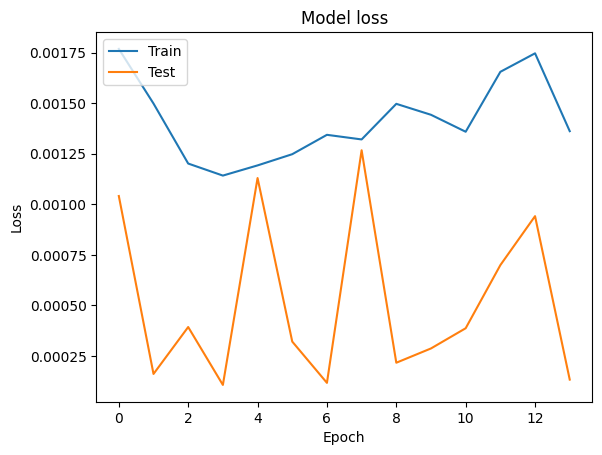

In [199]:
# Plot training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

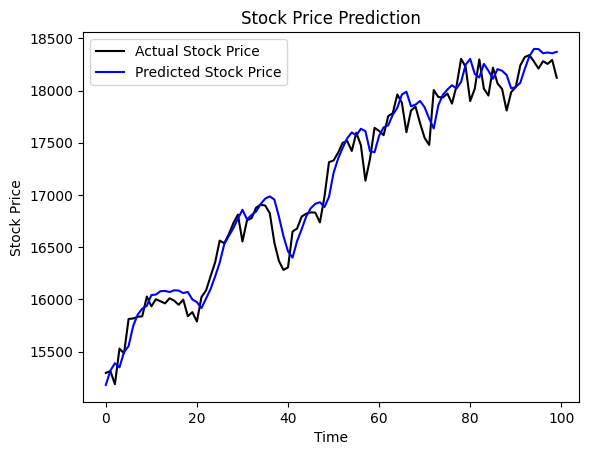

In [208]:
# Find a random place and predict those 50 prices 
# Plot the actual and predicted stock prices alongside each other

random_index = random.randint(0, len(X) - 50)
X_test = X[-100:]
Y_test = Y[-100:]
predictions = model.predict(X_test, verbose=0)

predictions = scaler.inverse_transform(predictions)
actual = scaler.inverse_transform(Y_test.reshape(-1, 1))

time_sequence = np.arange(len(actual))

plt.plot(time_sequence, actual.flatten(), color='black', label='Actual Stock Price',  markersize=4) 
plt.plot(time_sequence, predictions.flatten(), color='blue', label='Predicted Stock Price', markersize=4) 

plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

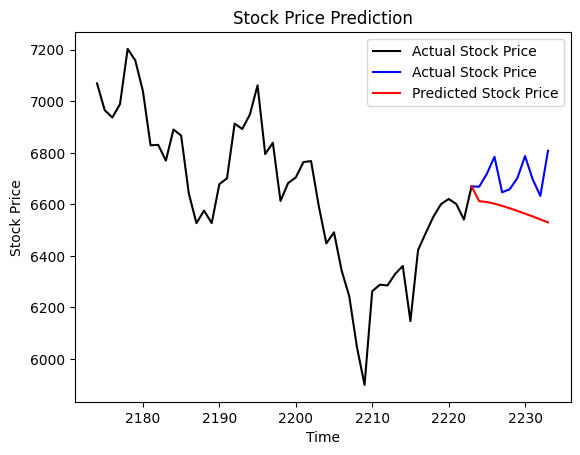

In [220]:
# Predict the next 50 prices from a random point in the dataset
# This time the model is predicting off its own predictions to create future 50 stocks
# Plotting alongside actual stock prices

future_stocks = 10
previous_stocks = 50
random_index = random.randint(0, len(X) - future_stocks)

current_sequence = X[random_index:random_index+1]
predictions = []
for _ in range(future_stocks):
    # Assume current_sequence is shaped [1, timesteps, features]
    predicted_stock_price = model.predict(current_sequence, verbose=0)
    # Ensure we correctly extract a single scalar value from the prediction
    predicted_value = predicted_stock_price[0, 0]  # Assuming the prediction shape is [1, 1]
    predictions.append(predicted_value)
    # Roll current_sequence to make space for the new prediction
    current_sequence = np.roll(current_sequence, -1, axis=1)
    # Insert the predicted_value into the last position of the sequence
    current_sequence[0, -1] = predicted_value  # Assuming a single feature for simplicity

predictions = np.array(predictions).reshape(-1, 1)
predictions = scaler.inverse_transform(predictions)

actual_segment = scaler.inverse_transform(Y[random_index-previous_stocks:random_index+future_stocks].reshape(-1, 1))
actual_segment = actual_segment.flatten()
predictions = np.insert(predictions, 0, np.array([actual_segment[previous_stocks-1]]))

time_sequence_initial = np.arange(random_index, random_index + previous_stocks)
time_sequence_split_actual = np.arange(random_index + previous_stocks - 1, random_index + previous_stocks + future_stocks)
time_sequence_split_predicted = np.arange(random_index + previous_stocks - 1, random_index + previous_stocks + future_stocks)

plt.plot(time_sequence_initial, actual_segment[:previous_stocks], color='black', label='Actual Stock Price', markersize=4) 
plt.plot(time_sequence_split_actual, actual_segment[previous_stocks-1:previous_stocks+future_stocks], label='Actual Stock Price', color='blue', markersize=4)
plt.plot(time_sequence_split_predicted, predictions, color='red', label='Predicted Stock Price', markersize=4)

plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [224]:
last = X[-1:]
scaler.inverse_transform(model.predict(last))

1/1 [==============================] - 0s 21ms/step


array([[18370.662]], dtype=float32)